# Objectives

* Handiling Techstack: PyG, NetworkX
* Characteristics of the dataset
* Visualizing Data

In [11]:
import os
import collections

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import torch
from torch import nn
from torch import Tensor
import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import WebKB
import networkx as nx
from networkx.algorithms import community

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_dir = ',/data'
os.makedirs(data_dir, exist_ok=True)

In [6]:
# Download the dataset
dataset = WebKB(root=data_dir, name='texas')
data = dataset[0] 

Processing...
Done!


* Nodes -> web pages
* Edges -> connection between web pages 
* Nodes are classified into 5 classes: Student, Project, Course, Staff, Faculty

In [53]:
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of nodes: {data.num_edges}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

# Edge analysis
edge_index = data.edge_index.numpy()
print(edge_index.shape)
edge_example_outward = edge_index[:, np.where(edge_index[0] == 15)[0]] # outdegree
edge_example_inward = edge_index[:, np.where(edge_index[1] == 15)[0]]  # indegree
print(edge_example_outward)
print(edge_example_inward)

Number of nodes: 183
Number of nodes: 325
Has isolated nodes: False
Has self-loops: True
Is undirected: False
(2, 325)
[[ 15  15  15  15  15]
 [ 15  16  22  65 165]]
[[ 15  20  57  92 174]
 [ 15  15  15  15  15]]


In [54]:
edge_index[:, np.where(edge_index[0] == 15)[0]]
# edge_index[:np.where(edge_index[1] == 15)[0]]

array([[ 15,  15,  15,  15,  15],
       [ 15,  16,  22,  65, 165]])

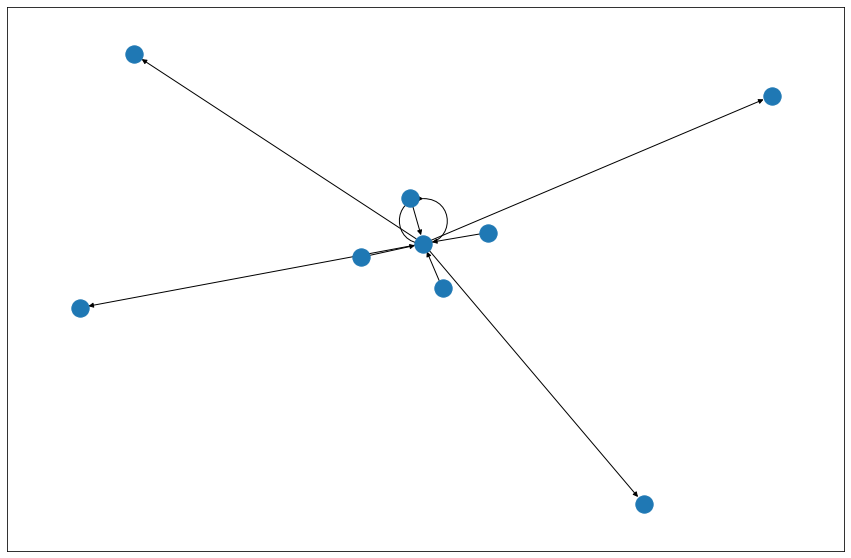

In [63]:
# Draw the network with networkx
node_example = np.unique(np.concatenate([edge_example_outward.flatten(), 
                                        edge_example_inward.flatten()]))
node_example

plt.figure(figsize=(15, 10))
G = nx.DiGraph()
G.add_nodes_from(node_example)
G.add_edges_from(list(zip(edge_example_outward[0], edge_example_outward[1])))
G.add_edges_from(list(zip(edge_example_inward[0], edge_example_inward[1])))
nx.draw_networkx(G, with_labels=False)

Average node degree: 1.78


,count,mean,std,min,25%,50%,75%,max
0,183.0,3.55,7.93,1.0,1.0,2.0,4.0,104.0


Degree:  183
Sum degree:  650


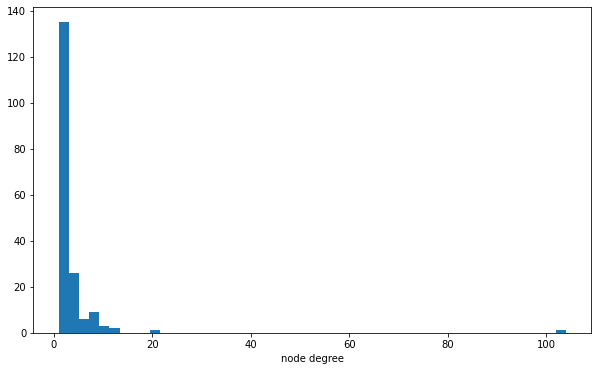

In [59]:
# Node degree : #edges joining a vertex in a graph
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')

# Visualizing the node degree as a histogram

G = to_networkx(data, to_undirected=False)
degrees = [val for (node, val) in G.degree()]
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
print("Degree: ", len(degrees))
print("Sum degree: ",sum(degrees))

plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50)
plt.xlabel("node degree")
plt.show()

High degree of a node means that it is connected to many nodes, hence nodes with high degree are likely to be important.

threshold 0.049450549450549455


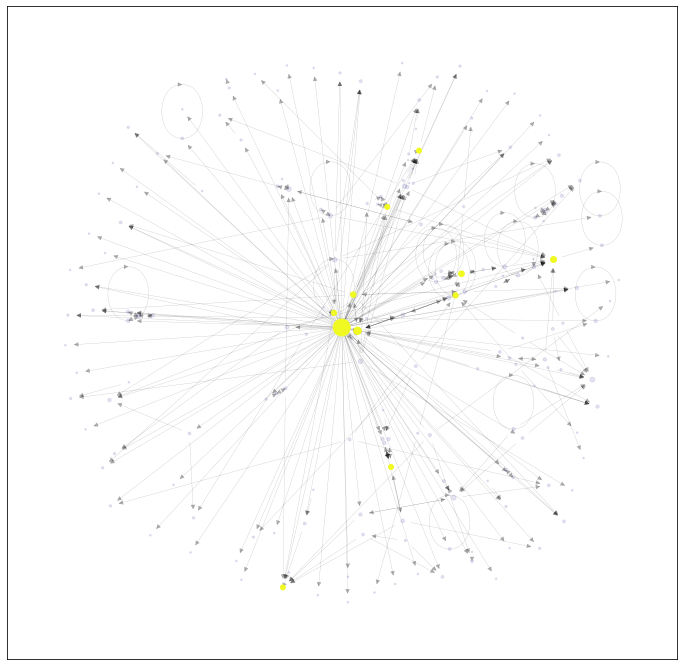

In [76]:
# Top 10 nodes with highest node degree
G = to_networkx(data, to_undirected=False)
pos = nx.spring_layout(G, seed=4)

cent = nx.degree_centrality(G)
node_size = list(map(lambda x: x * 500, cent.values()))

cent_array = np.array(list(cent.values()))
threshold = sorted(cent_array, reverse=True)[10]
print("threshold", threshold)
cent_bin = np.where(cent_array >= threshold, 1, 0.1)

plt.figure(figsize=(12, 12))
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size,
                              cmap=plt.cm.plasma,
                              node_color=cent_bin,
                              nodelist=list(cent.keys()),
                              alpha=cent_bin)
edges = nx.draw_networkx_edges(G, pos, width=0.25, alpha=0.3)
plt.show()
# cent_bin
# len(sorted(cent_array, reverse=True))

In [81]:
# Features
print(f'Number of features: {data.num_node_features}')

# Display sum of features
print(len(data.x[0]))
print(data.x[1][:20]) # composed with 0s and 1s
print(data.x.shape)

Number of features: 1703
1703
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
        0., 0.])
torch.Size([183, 1703])


In [83]:
# Classes
print(f'Number of Classes: {dataset.num_classes}')

Number of Classes: 5


In [85]:
label_dict = {
    0: "student",
    1: "project",
    2: "course",
    3: "staff",
    4: "faculty"
}
print(data.y[:10])
print(data.y.shape)

tensor([3, 0, 2, 3, 4, 3, 0, 0, 3, 0])
torch.Size([183])


Counter({3: 101, 0: 33, 4: 30, 2: 18, 1: 1})
{3: 101, 0: 33, 2: 18, 4: 30, 1: 1}
[33, 1, 18, 101, 30]


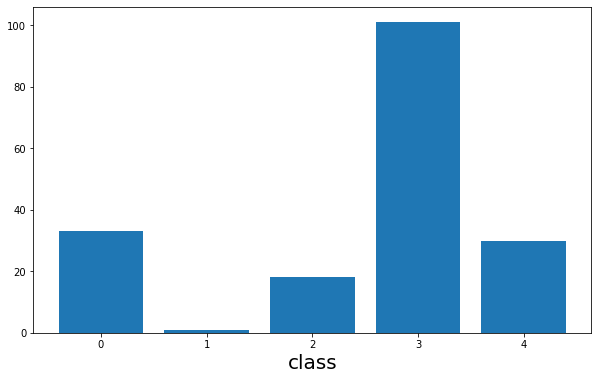

In [96]:
# Number of nodes for each class
# print(data.y)
counter = collections.Counter(data.y.numpy())
print(counter)
counter = dict(counter)
print(counter)

count = [x[1] for x in sorted(counter.items())]
print(count)

plt.figure(figsize=(10, 6))
plt.bar(range(5), count)
plt.xlabel("class", size=20)
plt.show()

Highest number of classes is 101 which is belong to class 3, and the lowest number is 1 in class 1. Hence this is imbalance, this needs to be considered when training the model.

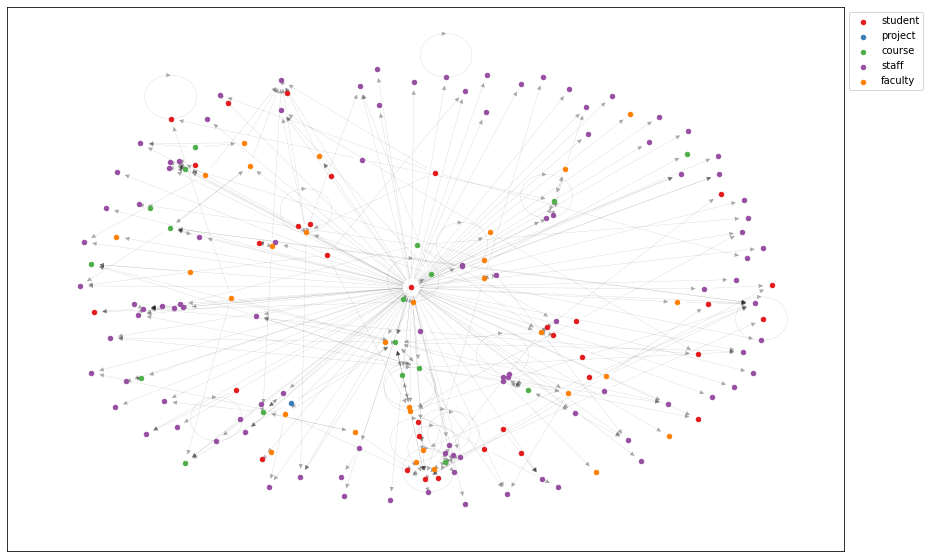

In [114]:
G = to_networkx(data, to_undirected=False)

node_color = []
nodelist = [[], [], [], [], []] # based on #classes

colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']
labels = data.y
for n, i in enumerate(labels):
    node_color.append(colorlist[i])
    nodelist[i].append(n)

# print(nodelist)
# print(node_color)

pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(15, 10))
labellist = list(label_dict.values())
# print(labellist)

for num, i in enumerate(zip(nodelist, labellist)):
    n, l = i[0], i[1]
    nx.draw_networkx_nodes(G, pos, nodelist=n, node_size=20, node_color=colorlist[num], label=l)

nx.draw_networkx_edges(G, pos, width=0.2, alpha=0.3)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig("Texas_dataset.png", dpi=150, bbox_inches='tight')
# print(list(zip(nodelist, labellist)))

This depicts taht nodes are not connected to each other in the same class. A better approach is needed to analyze this point.

# Homophily and Heterophily

* homophily -> nodes with same characteristics are often connected.
* heterophily -> nodes with different characteristics are often connected

connected_labels_set:  (2, 325)
label: 0
138 edges
{4: 30, 3: 94, 0: 3, 2: 11}
{4: 30, 3: 94, 0: 3, 2: 11, 1: 0}
[3, 0, 11, 94, 30]
label: 1
2 edges
{2: 2}
{2: 2, 0: 0, 1: 0, 3: 0, 4: 0}
[0, 0, 2, 0, 0]
label: 2
58 edges
{3: 39, 4: 12, 2: 6, 0: 1}
{3: 39, 4: 12, 2: 6, 0: 1, 1: 0}
[1, 0, 6, 39, 12]
label: 3
54 edges
{2: 26, 0: 7, 3: 20, 4: 1}
{2: 26, 0: 7, 3: 20, 4: 1, 1: 0}
[7, 0, 26, 20, 1]
label: 4
73 edges
{0: 24, 3: 25, 4: 6, 2: 18}
{0: 24, 3: 25, 4: 6, 2: 18, 1: 0}
[24, 0, 18, 25, 6]
(5, 5)


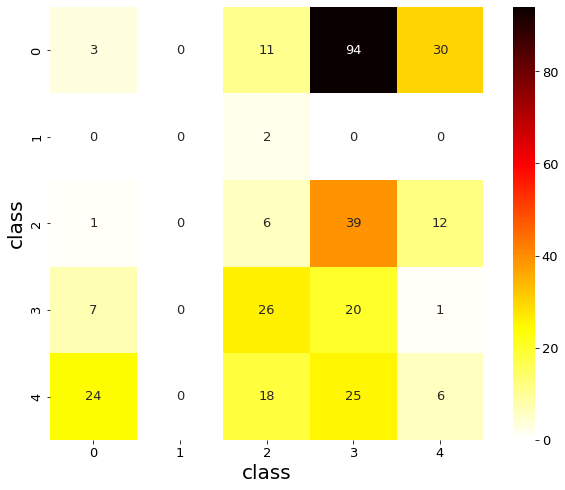

In [180]:
labels = data.y.numpy()
connected_labels_set = list(map(lambda x: labels[x], data.edge_index.numpy()))
# x = [1, 3, 5]
# y = [7, 7, 0]
# list(map(lambda x: x *2, x))
# data.edge_index.shape
# np.shape(connected_labels_set)
connected_labels_set = np.array(connected_labels_set)
print("connected_labels_set: ", connected_labels_set.shape)

def add_missing_keys(counter, classes):
    for x in classes:
        if x not in counter.keys():
            counter[x] = 0
    return counter

label_connection_counts = []
for i in range(5):
    print(f'label: {i}')
    connected_labels = connected_labels_set[:,
                                           np.where(connected_labels_set[0] == i)[0]] # slicing operation on the array
    print(connected_labels.shape[1], "edges")
    # print(connected_labels[1])
    counter = collections.Counter(connected_labels[1])
    counter = dict(counter)
    print(counter)
    counter = add_missing_keys(counter, range(5))
    print(counter)
    items = sorted(counter.items())
    # print(items)
    items = [x[1] for x in items]
    print(items)
    label_connection_counts.append(items)
    
label_connection_counts = np.array(label_connection_counts)
print(label_connection_counts.shape)


plt.figure(figsize=(9, 7))
plt.rcParams["font.size"] = 13
hm = sns.heatmap(label_connection_counts, annot=True, cmap='hot_r', cbar=True, square=True)
plt.xlabel('class', size=20)
plt.ylabel('class', size=20)
plt.tight_layout()
plt.show()